In [1]:
def Stock_Forecast(Instrument, TRIAL, PATIENCE):
    #importing required libraries
    from sklearn.preprocessing import MinMaxScaler
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, LSTM
    import pandas as pd
    import numpy as np
    
    import tensorflow as tf
    import random as rn
    import os

    os.environ['PYTHONHASHSEED'] = '0'

    # Setting the seed for numpy-generated random numbers
    np.random.seed(37)

    # Setting the seed for python random numbers
    rn.seed(1254)

    # Setting the graph-level random seed.
    tf.set_random_seed(89)

    from keras import backend as K

    session_conf = tf.ConfigProto(
          intra_op_parallelism_threads=1,
          inter_op_parallelism_threads=1)

    #Force Tensorflow to use a single thread
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

    K.set_session(sess)
    
    # read the data
    d=pd.read_excel("D:\GoogleDrive\custom Codes\TechAnalyis\Book3.xlsx")
    
    # remove leading and trainling blank spaces from column names
    d.columns=d.columns.str.strip()
    
    # remove leanding and trailing blank spaces from TRADING CODEs
    d['TRADING CODE']=d['TRADING CODE'].str.strip()
    
    # select the Instrument of your interest
    df=d[d['TRADING CODE']==Instrument]
    
    # remove rows with invalid values
    df=df[~(df['LTP']==0)|(df['HIGH']==0)|(df['LOW']==0)|(df['OPENP']==0)|(df['CLOSEP']==0)]
    
    # remove rows with invalid values
    df=df[~(df['LTP']==0)|(df['HIGH']==0)|(df['LOW']==0)|(df['OPENP']==0)|(df['CLOSEP']==0)]
    
    # sort the data as per date
    df=df.sort_values(['DATE'], ascending=True)
    
    # keep only the required columns
    dx=df[['DATE', 'CLOSEP']]
    
    # set the date column as index
    dx.set_index(['DATE'], inplace=True)
    
    # turn the column into a numpy array
    dataset=dx.values
    
    # set first 75% values as training data and the rest as test data
    train = dataset[:int(len(dataset)*.75),:]
    valid = dataset[int(len(dataset)*.75):,:]
    
    # scaling the values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    # creating x_train and y_train, seeting the array as 0 dimensional, each time x_train.append is giving 30 values with 0 dimension,then set each as 
    # rows
    x_train, y_train = [], []
    for i in range(30,len(train)):
        x_train.append(scaled_data[i-30:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # turn x_train as three dimensional
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    
    # compile the model
    import keras
    from keras.models import load_model
    
    # set the model saved file name
    fn=Instrument+'weights.hdf5'
    model.compile(loss='mean_absolute_percentage_error', optimizer='adam') # model will try to minimize mape
    ks = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=PATIENCE) # model will wait for the next 200 model, if no improvement, stop
    checkpointer = keras.callbacks.ModelCheckpoint(filepath=fn, monitor='loss', verbose=1, save_best_only=True) # best model so far will be saved
    model.fit(x_train, y_train, epochs=TRIAL, validation_split=0.1, verbose=0, callbacks=[ks, checkpointer]) # now the fitted model will run 4000 trials for best model
    model=load_model(fn) # now the best model will be loaded from saved file

    #predicting values, using past 30 from the train data
    inputs = dx.values[len(dx) - len(valid) - 30:]
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    
    # creating X_test
    X_test = []
    for i in range(30,inputs.shape[0]):
        X_test.append(inputs[i-30:i,0])
    X_test = np.array(X_test)
    
    # turn X_test into 3 dimensional
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    # forecasting future values ie calculating y_test
    closing_price = model.predict(X_test)
    cl=closing_price

    # turning the forecasting values back to original scale
    closing_price = scaler.inverse_transform(closing_price)
    
    # model evaluate
    train_acc = model.evaluate(x_train, y_train, verbose=0)
    test_acc = model.evaluate(X_test, cl, verbose=0)
    #print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
        
    # calculating MAPE
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    mape=sum(abs(valid-closing_price)/abs(valid))*100*(1/len(valid))
    
    #to plot within notebook
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    # for plotting
    plt.figure(figsize=(20,10))
    train = dx[:int(len(dataset)*.75)]
    valid = dx[int(len(dataset)*.75):]
    valid['Predictions'] = closing_price
    plt.plot(train['CLOSEP'])
    plt.plot(valid[['CLOSEP','Predictions']])
    
    print('The Root Mean Squared of the Model is: %.3f' %(rms))
    print('The Mean Absolute Percentage Error of the Model is: %.3f' %(mape))

Using TensorFlow backend.



Epoch 00001: loss improved from inf to 52.10659, saving model to GPweights.hdf5

Epoch 00002: loss improved from 52.10659 to 17.88155, saving model to GPweights.hdf5

Epoch 00003: loss improved from 17.88155 to 9.85864, saving model to GPweights.hdf5

Epoch 00004: loss improved from 9.85864 to 8.80515, saving model to GPweights.hdf5

Epoch 00005: loss did not improve from 8.80515

Epoch 00006: loss improved from 8.80515 to 8.76673, saving model to GPweights.hdf5

Epoch 00007: loss improved from 8.76673 to 7.81257, saving model to GPweights.hdf5

Epoch 00008: loss did not improve from 7.81257

Epoch 00009: loss improved from 7.81257 to 7.74685, saving model to GPweights.hdf5

Epoch 00010: loss improved from 7.74685 to 7.46655, saving model to GPweights.hdf5

Epoch 00011: loss did not improve from 7.46655

Epoch 00012: loss did not improve from 7.46655

Epoch 00013: loss did not improve from 7.46655

Epoch 00014: loss improved from 7.46655 to 7.33046, saving model to GPweights.hdf5

Epo


Epoch 00139: loss did not improve from 3.14901

Epoch 00140: loss did not improve from 3.14901

Epoch 00141: loss did not improve from 3.14901

Epoch 00142: loss did not improve from 3.14901

Epoch 00143: loss did not improve from 3.14901

Epoch 00144: loss did not improve from 3.14901

Epoch 00145: loss did not improve from 3.14901

Epoch 00146: loss did not improve from 3.14901

Epoch 00147: loss did not improve from 3.14901

Epoch 00148: loss did not improve from 3.14901

Epoch 00149: loss did not improve from 3.14901

Epoch 00150: loss did not improve from 3.14901

Epoch 00151: loss did not improve from 3.14901

Epoch 00152: loss did not improve from 3.14901

Epoch 00153: loss improved from 3.14901 to 3.14132, saving model to GPweights.hdf5

Epoch 00154: loss did not improve from 3.14132

Epoch 00155: loss did not improve from 3.14132

Epoch 00156: loss did not improve from 3.14132

Epoch 00157: loss improved from 3.14132 to 3.05412, saving model to GPweights.hdf5

Epoch 00158: lo


Epoch 00300: loss did not improve from 2.85533

Epoch 00301: loss did not improve from 2.85533

Epoch 00302: loss did not improve from 2.85533

Epoch 00303: loss did not improve from 2.85533

Epoch 00304: loss did not improve from 2.85533

Epoch 00305: loss did not improve from 2.85533

Epoch 00306: loss did not improve from 2.85533

Epoch 00307: loss did not improve from 2.85533

Epoch 00308: loss did not improve from 2.85533

Epoch 00309: loss did not improve from 2.85533

Epoch 00310: loss did not improve from 2.85533

Epoch 00311: loss improved from 2.85533 to 2.84028, saving model to GPweights.hdf5

Epoch 00312: loss did not improve from 2.84028

Epoch 00313: loss did not improve from 2.84028

Epoch 00314: loss did not improve from 2.84028

Epoch 00315: loss did not improve from 2.84028

Epoch 00316: loss did not improve from 2.84028

Epoch 00317: loss did not improve from 2.84028

Epoch 00318: loss did not improve from 2.84028

Epoch 00319: loss did not improve from 2.84028

Epo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The Root Mean Squared of the Model is: 4.538
The Mean Absolute Percentage Error of the Model is: 0.865


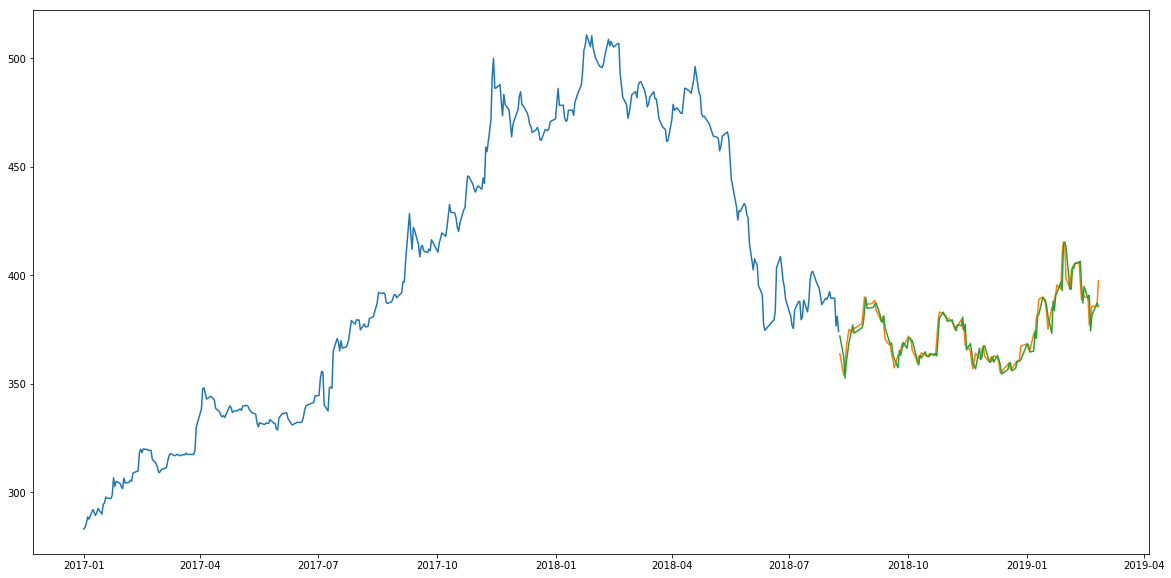

In [2]:
Stock_Forecast('GP', 4000, 200)